# Deep Q-Learning

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [1]:
# !pip3 install gym pyvirtualdisplay
# !pip3 install ffmpeg xvfbwrapper PyOpenGL
# !sudo apt-get install -y xvfb python-opengl ffmpeg

In [2]:
# !pip3 install --upgrade setuptools --user
# !pip3 install ez_setup
# !pip3 install gym[atari]
# !pip3 install gym[accept-rom-license]

For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [3]:
%matplotlib inline

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN, DQN_LSTM
from config import *

import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

## Understanding the environment

In the following cell, we initialize our game of __Breakout__ and you can see how the environment looks like. For further documentation of the of the environment refer to https://gym.openai.com/envs.

In breakout, we will use 3 actions "fire", "left", and "right". "fire" is only used to reset the game when a life is lost, "left" moves the agent left and "right" moves the agent right.

In [4]:
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()

In [5]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

In [6]:
double_dqn = True # set to True if using double DQN agent

if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

agent = Agent(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

e:\Personal_Stuff\UIUC\Sem_2\DL for CV (CS_444)\Assignments\assignment5\agent_double.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(a)


episode: 0   score: 0.0   memory length: 123   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 0.0
episode: 1   score: 4.0   memory length: 418   epsilon: 1.0    steps: 295    lr: 0.0001     evaluation reward: 2.0
episode: 2   score: 3.0   memory length: 648   epsilon: 1.0    steps: 230    lr: 0.0001     evaluation reward: 2.3333333333333335
episode: 3   score: 2.0   memory length: 845   epsilon: 1.0    steps: 197    lr: 0.0001     evaluation reward: 2.25
episode: 4   score: 2.0   memory length: 1043   epsilon: 1.0    steps: 198    lr: 0.0001     evaluation reward: 2.2
episode: 5   score: 3.0   memory length: 1291   epsilon: 1.0    steps: 248    lr: 0.0001     evaluation reward: 2.3333333333333335
episode: 6   score: 1.0   memory length: 1461   epsilon: 1.0    steps: 170    lr: 0.0001     evaluation reward: 2.142857142857143
episode: 7   score: 1.0   memory length: 1633   epsilon: 1.0    steps: 172    lr: 0.0001     evaluation reward: 2.0
episode: 8   score: 3.0   memor

e:\Personal_Stuff\UIUC\Sem_2\DL for CV (CS_444)\Assignments\assignment5\memory.py:29: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample = np.array(sample, dtype=object)
e:\Personal_Stuff\UIUC\Sem_2\DL for CV (CS_444)\Assignments\assignment5\agent_double.py:78: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour,

episode: 548   score: 2.0   memory length: 100109   epsilon: 0.9997822000000047    steps: 198    lr: 0.0001     evaluation reward: 1.41
episode: 549   score: 2.0   memory length: 100306   epsilon: 0.9993921400000132    steps: 197    lr: 0.0001     evaluation reward: 1.43
episode: 550   score: 0.0   memory length: 100429   epsilon: 0.9991486000000185    steps: 123    lr: 0.0001     evaluation reward: 1.41
episode: 551   score: 2.0   memory length: 100647   epsilon: 0.9987169600000279    steps: 218    lr: 0.0001     evaluation reward: 1.43
episode: 552   score: 0.0   memory length: 100769   epsilon: 0.9984754000000331    steps: 122    lr: 0.0001     evaluation reward: 1.41
episode: 553   score: 0.0   memory length: 100891   epsilon: 0.9982338400000383    steps: 122    lr: 0.0001     evaluation reward: 1.39
episode: 554   score: 2.0   memory length: 101089   epsilon: 0.9978418000000469    steps: 198    lr: 0.0001     evaluation reward: 1.41
episode: 555   score: 0.0   memory length: 10121

KeyboardInterrupt: 

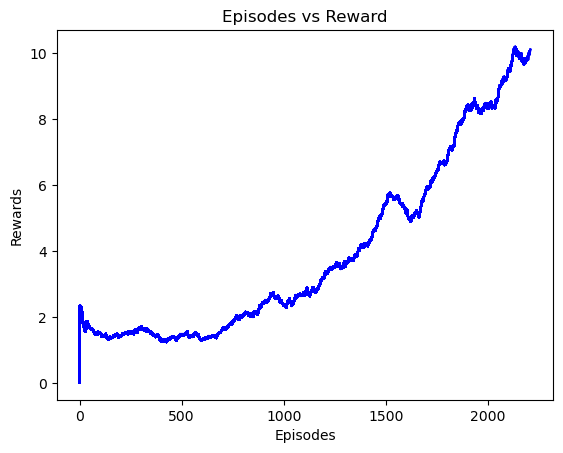

In [7]:
rewards, episodes = [], []
best_eval_reward = 0
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = torch.tensor([[0]]).cuda()
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state

        next_state, reward, terminated, truncated, info = env.step(action + 1)

        done = terminated or truncated

        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory
        agent.memory.push(deepcopy(frame_next_state), action.cpu(), r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame): # You can set train_frame to a lower value while testing your starts training earlier
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]

        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards')
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/breakout_double_dqn.png") # save graph for training visualization

            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'],"    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 8 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/breakout_double_dqn.pth")
                best_eval_reward = np.mean(evaluation_reward)


In [ ]:
# 200 episodes: 1.5
# 400 episodes: 1.5
# 600 episodes: 1.5
# 1000 episodes: 1.8
# 1200 episodes: 2.9
# 1400 episodes: 4.2
# 1600 episodes: 5.0
# 1800 episodes: 6.6 
# 2000 episodes: 9.1
# 2200 episodes: 10.1

# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

In [11]:
torch.save(agent.policy_net, "./save_model/breakout_double_dqn_latest.pth")

In [13]:
# from gym.wrappers import Monitor # If importing monitor raises issues, try using `from gym.wrappers import RecordVideo`
# import glob
# import io
# import base64

# from IPython.display import HTML
# from IPython import display as ipythondisplay

# from pyvirtualdisplay import Display

# # Displaying the game live
# def show_state(env, step=0, info=""):
#     plt.figure(3)
#     plt.clf()
#     plt.imshow(env.render(mode='rgb_array'))
#     plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
#     plt.axis('off')

#     ipythondisplay.clear_output(wait=True)
#     ipythondisplay.display(plt.gcf())

# # Recording the game and replaying the game afterwards
# def show_video():
#     mp4list = glob.glob('video/*.mp4')
#     if len(mp4list) > 0:
#         mp4 = mp4list[0]
#         video = io.open(mp4, 'r+b').read()
#         encoded = base64.b64encode(video)
#         ipythondisplay.display(HTML(data='''<video alt="test" autoplay
#                 loop controls style="height: 400px;">
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii'))))
#     else:
#         print("Could not find video")


# def wrap_env(env):
#     env = Monitor(env, './video', force=True)
#     return env





import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN, DQN_LSTM
from config import *

import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

from gym.wrappers import RecordVideo # If importing monitor raises issues, try using `from gym.wrappers import RecordVideo`
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

env = gym.make('BreakoutDeterministic-v4', render_mode='rgb_array')
state = env.reset()
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video_double/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video style="height: 400px;" controls="" loop="" autoplay="" alt="test">
                <source type="video/mp4" src="data:video/mp4;base64,{0}">
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = RecordVideo(env, './video_double')
    return env

from agent import Agent
action_size = 3


# Load agent
agent = Agent(action_size)
agent.load_policy_net("./save_model/breakout_double_dqn.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = wrap_env(env)

done = False
score = 0
step = 0
state, _ = env.reset()
next_state = state
life = number_lives
history = np.zeros([5, 84, 84], dtype=np.uint8)
get_init_state(history, state, HISTORY_SIZE)
frame = 0
while not done:
#     show_state(env,step) # uncommenting this provides another way to visualize the game
    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = 0
    else:
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
    state = next_state

    next_state, reward, done, _, info = env.step(action + 1)

    frame_next_state = get_frame(next_state)
    history[4, :, :] = frame_next_state
    terminal_state = check_live(life, info['lives'])

    life = info['lives']
    r = np.clip(reward, -1, 1)
    r = reward

    # Store the transition in memory
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward

    history[:4, :, :] = history[1:, :, :]
env.close()
show_video()


Moviepy - Building video e:\Personal_Stuff\UIUC\Sem_2\DL for CV (CS_444)\Assignments\assignment5\video_double\rl-video-episode-0.mp4.
Moviepy - Writing video e:\Personal_Stuff\UIUC\Sem_2\DL for CV (CS_444)\Assignments\assignment5\video_double\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready e:\Personal_Stuff\UIUC\Sem_2\DL for CV (CS_444)\Assignments\assignment5\video_double\rl-video-episode-0.mp4


In [ ]:
# display = Display(visible=0, size=(300, 200))
# display.start()

# # Load agent
# # agent.load_policy_net("./save_model/breakout_dqn.pth")
# agent.epsilon = 0.0 # Set agent to only exploit the best action

# env = gym.make('BreakoutDeterministic-v4')
# env = wrap_env(env)

# done = False
# score = 0
# step = 0
# state = env.reset()
# next_state = state
# life = number_lives
# history = np.zeros([5, 84, 84], dtype=np.uint8)
# get_init_state(history, state)

# while not done:

#     # Render breakout
#     env.render()
# #     show_state(env,step) # uncommenting this provides another way to visualize the game

#     step += 1
#     frame += 1

#     # Perform a fire action if ball is no longer on screen
#     if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
#         action = 0
#     else:
#         action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
#     state = next_state

#     next_state, reward, done, info = env.step(action + 1)

#     frame_next_state = get_frame(next_state)
#     history[4, :, :] = frame_next_state
#     terminal_state = check_live(life, info['ale.lives'])

#     life = info['ale.lives']
#     r = np.clip(reward, -1, 1)
#     r = reward

#     # Store the transition in memory
#     agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
#     # Start training after random sample generation
#     score += reward

#     history[:4, :, :] = history[1:, :, :]
# env.close()
# show_video()
# display.stop()